<a href="https://colab.research.google.com/github/tfs4/image_pre-processing/blob/master/Adaptive_Median_Filter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from PIL import Image, ImageFilter

In [ ]:
def calculate_median(array):
    """Return the median of 1-d array"""
    sorted_array = np.sort(array) #timsort (O(nlogn))
    median = sorted_array[len(array)//2]
    return median

In [ ]:
def rgb2gray(rgb):
    if(len(rgb.shape) == 3):
        return np.uint8(np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140]))
    else:#already a grayscale
        return rgb

In [ ]:
def level_A(z_min, z_med, z_max, z_xy, S_xy, S_max):
    if(z_min < z_med < z_max):
        return level_B(z_min, z_med, z_max, z_xy, S_xy, S_max)
    else:
        S_xy += 2 #increase the size of S_xy to the next odd value.
        if(S_xy <= S_max): #repeat process
            return level_A(z_min, z_med, z_max, z_xy, S_xy, S_max)
        else:
            return z_med

In [ ]:
def level_B(z_min, z_med, z_max, z_xy, S_xy, S_max):
    if(z_min < z_xy < z_max):
        return z_xy
    else:
        return z_med

In [ ]:
def amf(image, initial_window, max_window):
    """runs the Adaptive Median Filter proess on an image"""
    xlength, ylength = image.shape #get the shape of the image.
    
    z_min, z_med, z_max, z_xy = 0, 0, 0, 0
    S_max = max_window
    S_xy = initial_window #dynamically to grow
    
    output_image = image.copy()
    
    for row in range(S_xy, xlength-S_xy-1):
        for col in range(S_xy, ylength-S_xy-1):
            filter_window = image[row - S_xy : row + S_xy + 1, col - S_xy : col + S_xy + 1] #filter window
            target = filter_window.reshape(-1) #make 1-dimensional
            z_min = np.min(target) #min of intensity values
            z_max = np.max(target) #max of intensity values
            z_med = calculate_median(target) #median of intensity values
            z_xy = image[row, col] #current intensity
            
            #Level A & B
            new_intensity = level_A(z_min, z_med, z_max, z_xy, S_xy, S_max)
            output_image[row, col] = new_intensity
    return output_image

In [ ]:

image_org = Image.open("IDRiD_001.jpg")

In [ ]:
image = np.array(image_org)

In [ ]:
grayscale_image = rgb2gray(image)

In [ ]:
output = amf(grayscale_image, 3, 11)

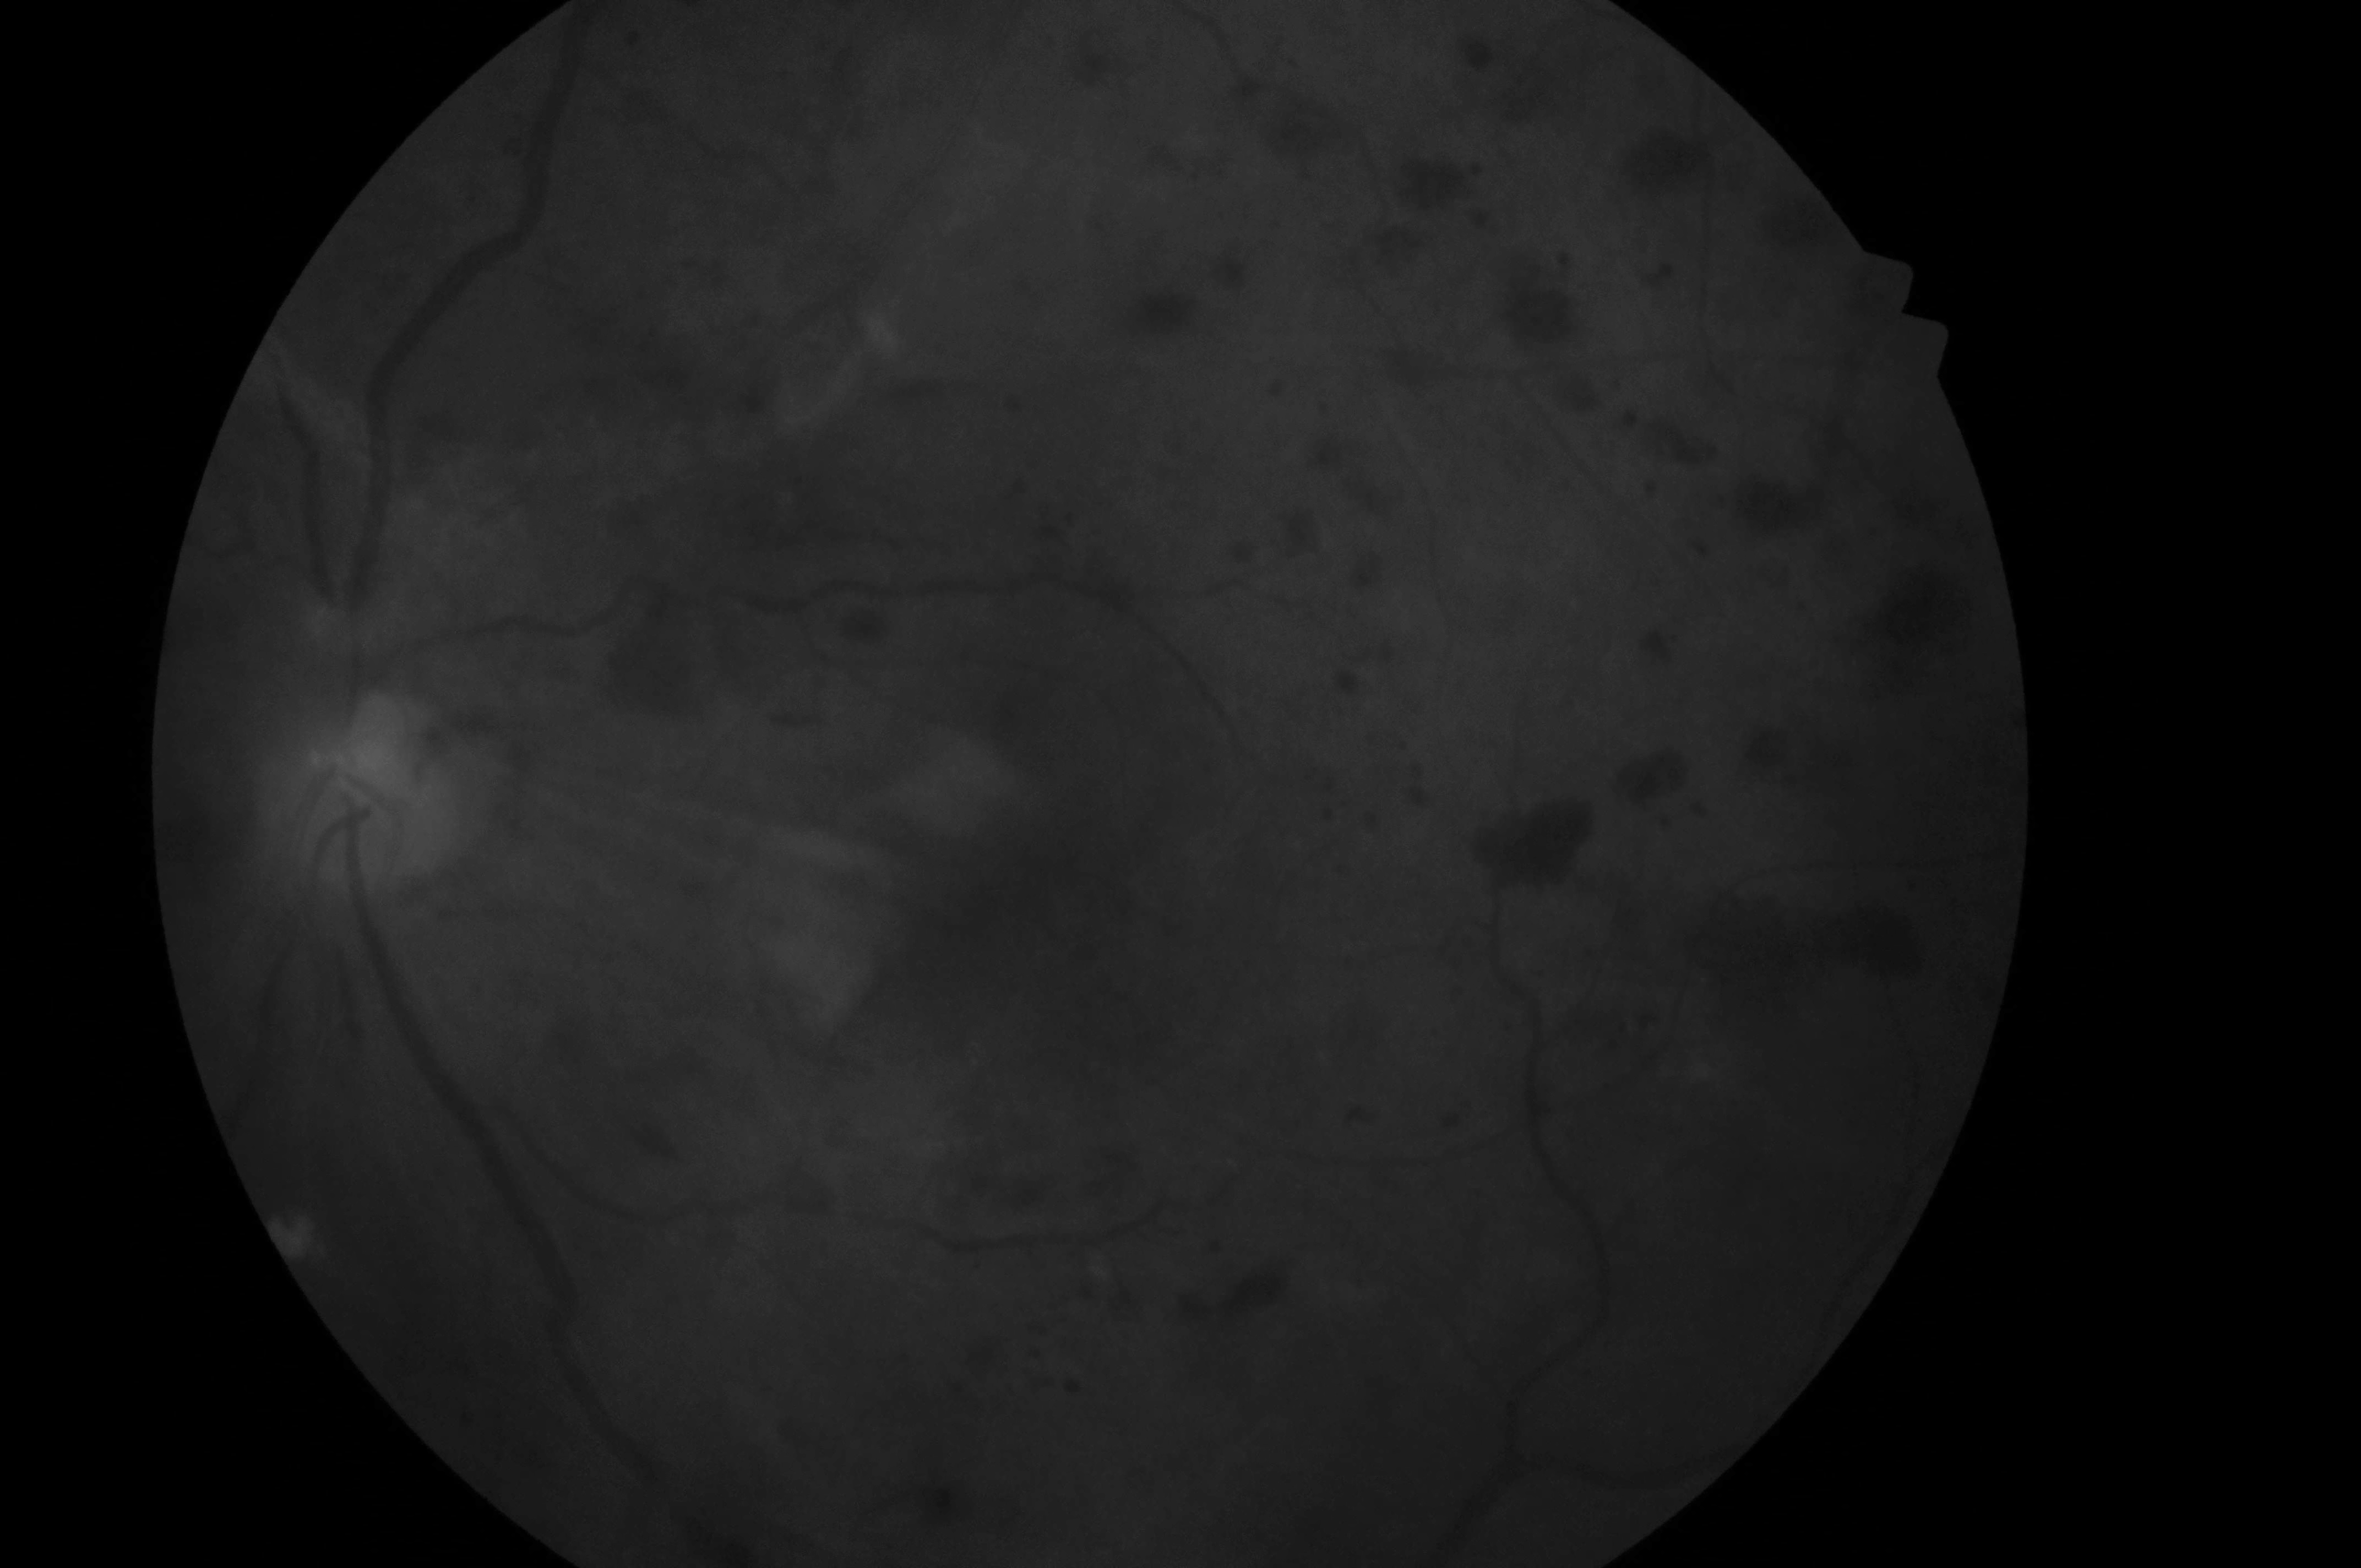

In [ ]:
Image.fromarray(output)

In [1]:
import numpy as np
from numba import njit,prange


@njit
def padding(img,pad):
    padded_img = np.zeros((img.shape[0]+2*pad,img.shape[1]+2*pad))
    padded_img[pad:-pad,pad:-pad] = img
    return padded_img

@njit(parallel=True)
def AdaptiveMedianFilter(img,s=3,sMax=7):
    if len(img.shape) == 3:
        raise Exception ("Single channel image only")

    H,W = img.shape
    a = sMax//2
    padded_img = padding(img,a)

    f_img = np.zeros(padded_img.shape)

    for i in prange(a,H+a+1):
        for j in range(a,W+a+1):
            value = Lvl_A(padded_img,i,j,s,sMax)
            f_img[i,j] = value

    return f_img[a:-a,a:-a] 

@njit
def Lvl_A(mat,x,y,s,sMax):
    window = mat[x-(s//2):x+(s//2)+1,y-(s//2):y+(s//2)+1]
    Zmin = np.min(window)
    Zmed = np.median(window)
    Zmax = np.max(window)

    A1 = Zmed - Zmin
    A2 = Zmed - Zmax

    if A1 > 0 and A2 < 0:
        return Lvl_B(window, Zmin, Zmed, Zmax)
    else:
        s += 2 
        if s <= sMax:
            return Lvl_A(mat,x,y,s,sMax)
        else:
             return Zmed

@njit
def Lvl_B(window, Zmin, Zmed, Zmax):
    h,w = window.shape

    Zxy = window[h//2,w//2]
    B1 = Zxy - Zmin
    B2 = Zxy - Zmax

    if B1 > 0 and B2 < 0 :
        return Zxy
    else:
        return Zmed